In [24]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

In [2]:
def month_string_to_number(string):
    """ month_string_to_number takes a month and turns it into the 
    corresponding number
    args:
        :string - each item is a string

    returns:
        :(out) - the equivalent of the month's number
    """
    m = {
        'jan': 1,
        'feb': 2,
        'mar': 3,
        'apr':4,
         'may':5,
         'jun':6,
         'jul':7,
         'aug':8,
         'sep':9,
         'oct':10,
         'nov':11,
         'dec':12
        }
    s = string.strip()[:3].lower()

    try:
        out = m[s]
        return out
    except:
        raise ValueError('Not a month')



In [99]:
path = '/Users/afugere/Desktop/UVM Masters/GraduateSemester2/STAT330/FinalProject/'
path2 = '/Users/abigailhotaling/Documents/STAT_330_Project/Data/'

In [100]:
data = pd.read_csv(path2+ 'Electricity_Residential_Price_New_England.csv')

In [101]:
#data.columns = ['Date', 'Electricity Residential Price: New England cents per kilowatthour']
data.columns = ['Date', 'Electricity Price']
# I also changed the column name for now, just to be a little bit shorter 
dates = []
months = []
years = []
for entry in data['Date']:
    dates.append(entry.replace('-', ' '))
    data['Month and Year'] = pd.Series(dates)
    months.append(month_string_to_number(str(entry[0:-3])))
    years.append(entry[-2:])
    data['Month'] = pd.Series(months)
    data['Year'] = pd.Series(years)
    

In [102]:
updated_years = []
for y in data['Year']:
    if int(y) > 19:
        updated_years.append('19'+y)
    else:
        updated_years.append('20'+y)
    data['Year'] = pd.Series(updated_years)

In [103]:
data['Day'] = [1]*len(data)

In [104]:
data['Datetime'] = pd.to_datetime(data[['Year', 'Month', 'Day']])
# I created a datetime object that we can plot by, 
# python can read the dates correctly so we don't need to sort anymore. 

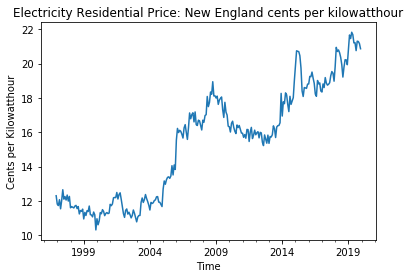

In [105]:
ax = data.plot(x = 'Datetime', y = 'Electricity Price', 
               title = 'Electricity Residential Price: New England cents per kilowatthour', legend = False)
ax.set_xlabel('Time')
ax.set_ylabel('Cents per Kilowatthour')
ax.format_xdata = mdates.DateFormatter('%Y-%m')

## Seasonal Subseries Plots

In [107]:
groups = data.groupby('Month')
months = pd.concat([pd.DataFrame({name:group['Electricity Price'].values}) for name, group in groups],
                   ignore_index=True, axis=1)
     
months.columns = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']

Text(0.5,1,'Seasonality Subplot')

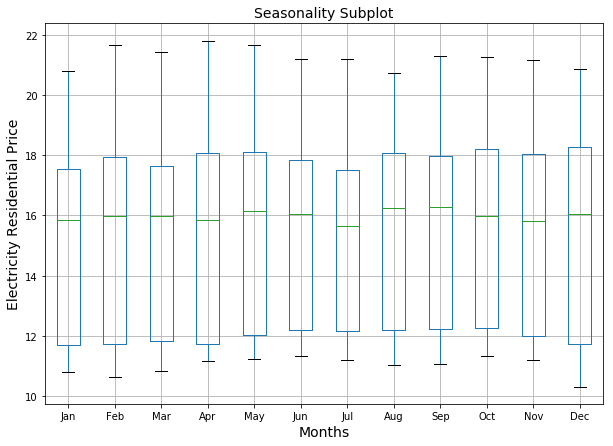

In [108]:
ax = months.boxplot(figsize = (10, 7))
ax.set_xlabel("Months", fontsize=14)
ax.set_ylabel('Electricity Residential Price', fontsize=14)
ax.set_title('Seasonality Subplot', fontsize=14)

There doesn't appear to be a large seasonal trend, that I can see at least. Let me know what you think. 

## Autoregressive Models

As some preliminary work lets fit some AR models. 
Some things to check:
    - Autocorrelation
    - Lag
    - Residuals
    
I completed this section following this link: https://machinelearningmastery.com/autoregression-models-time-series-forecasting-python/

### Lag Plot

There is a clear linear relationship between the previous month and the next month. 

/Users/abigailhotaling/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: FutureWarning: 'pandas.tools.plotting.lag_plot' is deprecated, import 'pandas.plotting.lag_plot' instead.
  


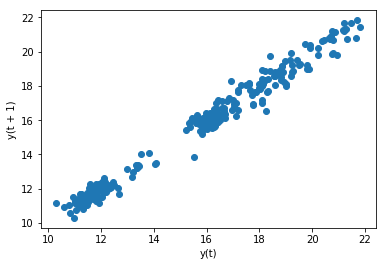

In [109]:
from pandas.tools.plotting import lag_plot
lag_plot(data['Electricity Price'])

In [117]:
dataframe = pd.concat([data['Electricity Price'].shift(1), data['Electricity Price']], axis=1)
dataframe.columns = ['t-1', 't+1']
result = dataframe.corr()
print(result)

          t+1         t
t+1  1.000000  0.991049
t    0.991049  1.000000


The correlation is very high, 0.99

/Users/abigailhotaling/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: FutureWarning: 'pandas.tools.plotting.autocorrelation_plot' is deprecated, import 'pandas.plotting.autocorrelation_plot' instead.
  


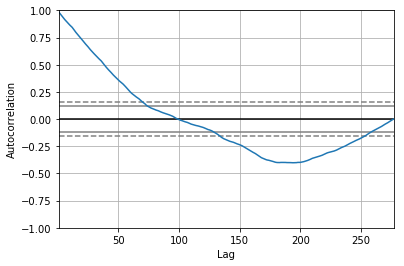

In [118]:
from pandas.tools.plotting import autocorrelation_plot
autocorrelation_plot(data['Electricity Price'])


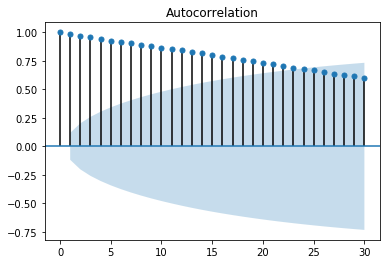

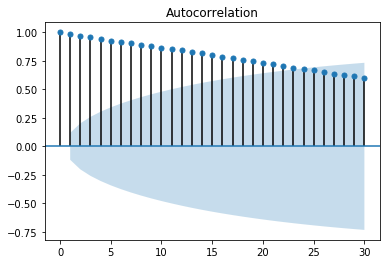

In [124]:
from statsmodels.graphics.tsaplots import plot_acf
plot_acf(data['Electricity Price'], lags=30)


### Percistance Model
The simplest model that we could use to make predictions would be to persist the last observation. We can call this a persistence model and it provides a baseline of performance for the problem that we can use for comparison with an autoregression model.

Right now we will try to predict the last 6 months of the data set. The predictions are made using a walk-forward validation model so that we can persist the most recent observations for the next month. This means that we are not making a 6-month forecast, but 6 1-month forecasts.

Test MSE: 0.211


Text(0,0.5,'Electricity Price')

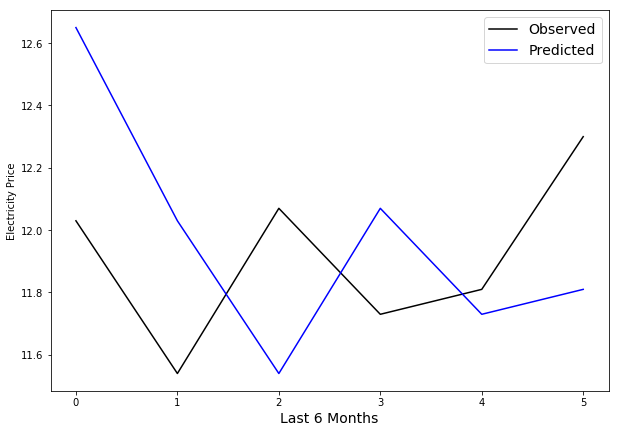

In [133]:
from sklearn.metrics import mean_squared_error
# create lagged dataset
values = data['Electricity Price']
dataframe = pd.concat([values.shift(1), values], axis=1)
dataframe.columns = ['t-1', 't+1']
# split into train and test sets
X = dataframe.values
train, test = X[1:len(X)-6], X[len(X)-6:]
train_X, train_y = train[:,0], train[:,1]
test_X, test_y = test[:,0], test[:,1]

# persistence model
def model_persistence(x):
    return x

# walk-forward validation
predictions = list()
for x in test_X:
    yhat = model_persistence(x)
    predictions.append(yhat)
test_score = mean_squared_error(test_y, predictions)
print('Test MSE: %.3f' % test_score)

# plot predictions vs expected
fig, ax = plt.subplots(figsize = (10,7))
ax.plot(test_y, color = 'black', label = 'Observed')
ax.plot(predictions, color = 'blue', label = 'Predicted')
ax.legend(loc='best', fontsize = 14)
ax.set_xlabel('Last 6 Months', fontsize=14)
ax.set_ylabel('Electricity Price')

### Auto Regressive Model

An autoregression model is a linear regression model that uses lagged variables as input variables.

We could calculate the linear regression model manually using the LinearRegession class in scikit-learn and manually specify the lag input variables to use.

Alternately, the statsmodels library provides an autoregression model that automatically selects an appropriate lag value using statistical tests and trains a linear regression model. It is provided in the AR class.

We can use this model by first creating the model AR() and then calling fit() to train it on our dataset. This returns an ARResult object.

Once fit, we can use the model to make a prediction by calling the predict() function for a number of observations in the future. This creates 1 6-month forecast, which is different from the persistence example above.



Lag: 15
Coefficients: [ 0.16783365  0.77046482  0.1928798   0.00809194  0.05382423 -0.07033925
 -0.01977511  0.00633278  0.00922454  0.01843735 -0.04428663  0.1595853
  0.24770711 -0.22604608 -0.09326255 -0.02537456]
predicted=12.496115, expected=12.030000
predicted=12.481482, expected=11.540000
predicted=12.483632, expected=12.070000
predicted=12.485574, expected=11.730000
predicted=12.538370, expected=11.810000
predicted=12.690125, expected=12.300000
Test MSE: 0.421


Text(0,0.5,'Electricity Price')

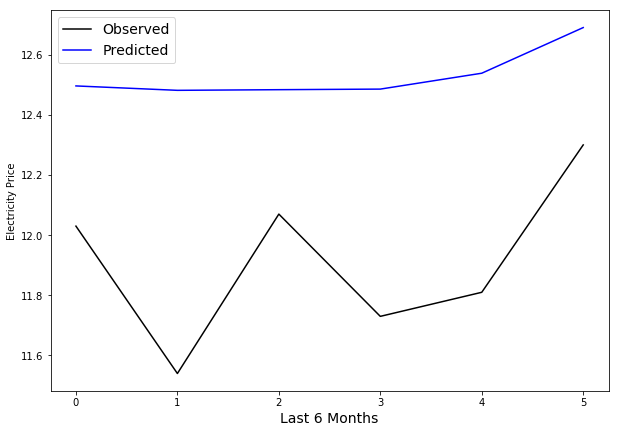

In [147]:
from statsmodels.tsa.ar_model import AR
X = data['Electricity Price'].values
train, test = X[1:len(X)-6], X[len(X)-6:]
# train autoregression
model = AR(train)
model_fit = model.fit()
print('Lag: %s' % model_fit.k_ar)
print('Coefficients: %s' % model_fit.params)
# make predictions
predictions = model_fit.predict(start=len(train), end=len(train)+len(test)-1, dynamic=False)
for i in range(len(predictions)):
    print('predicted=%f, expected=%f' % (predictions[i], test[i]))
error = mean_squared_error(test, predictions)
print('Test MSE: %.3f' % error)

# plot results
fig, ax = plt.subplots(figsize = (10,7))
ax.plot(test, color = 'black', label = 'Observed')
ax.plot(predictions, color = 'blue', label = 'Predicted')
ax.legend(loc='best', fontsize = 14)
ax.set_xlabel('Last 6 Months', fontsize=14)
ax.set_ylabel('Electricity Price')

predicted=12.496115, expected=12.030000
predicted=12.122357, expected=11.540000
predicted=11.668349, expected=12.070000
predicted=11.981520, expected=11.730000
predicted=11.843740, expected=11.810000
predicted=11.961971, expected=12.300000
Test MSE: 0.149


Text(0,0.5,'Electricity Price')

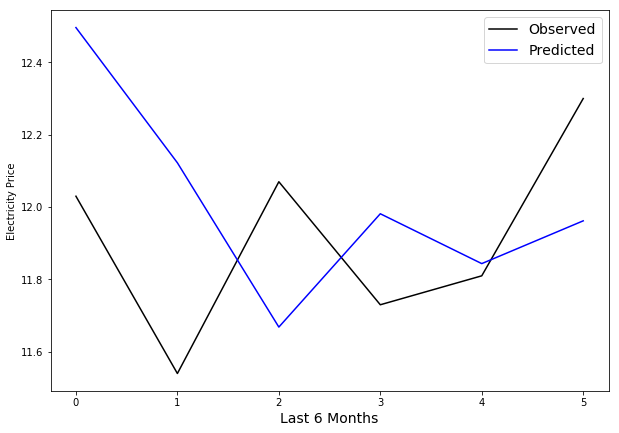

In [151]:
# split dataset
X = data['Electricity Price'].values
train, test = X[1:len(X)-6], X[len(X)-6:]
# train autoregression
model = AR(train)
model_fit = model.fit()
window = model_fit.k_ar
coef = model_fit.params

# walk forward over time steps in test
history = train[len(train)-window:]
history = [history[i] for i in range(len(history))]
predictions = list()
for t in range(len(test)):
    length = len(history)
    lag = [history[i] for i in range(length-window,length)]
    yhat = coef[0]
    for d in range(window):
        yhat += coef[d+1] * lag[window-d-1]
    obs = test[t]
    predictions.append(yhat)
    history.append(obs)
    print('predicted=%f, expected=%f' % (yhat, obs))
error = mean_squared_error(test, predictions)
print('Test MSE: %.3f' % error)
# plot results
fig, ax = plt.subplots(figsize = (10,7))
ax.plot(test, color = 'black', label = 'Observed')
ax.plot(predictions, color = 'blue', label = 'Predicted')
ax.legend(loc='best', fontsize = 14)
ax.set_xlabel('Last 6 Months', fontsize=14)
ax.set_ylabel('Electricity Price')

### Moving Average Model 
https://machinelearningmastery.com/moving-average-smoothing-for-time-series-forecasting-python/